# ECE 285 MLIP Assignment 4 - Image Denoising with Deep CNNs

## Arik Horodniceanu A53285765

## 1 Getting started

In [2]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 2 Creating noisy images of BSDS dataset with DataSet

### 1

In [4]:
dataset_root_dir = '/datasets/ee285f-public/bsds/'

### 2

In [5]:
class NoisyBSDSDataset(td.Dataset):
    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)
    def __len__(self):
        return len(self.files)
    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
        format(self.mode, self.image_size, self.sigma)
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        clean = clean.crop([i, j, i + 180, j + 180])
        transform = tv.transforms.Compose([tv.transforms.ToTensor(),\
                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        clean = transform(clean)
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean


### 3

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

<IPython.core.display.Javascript object>


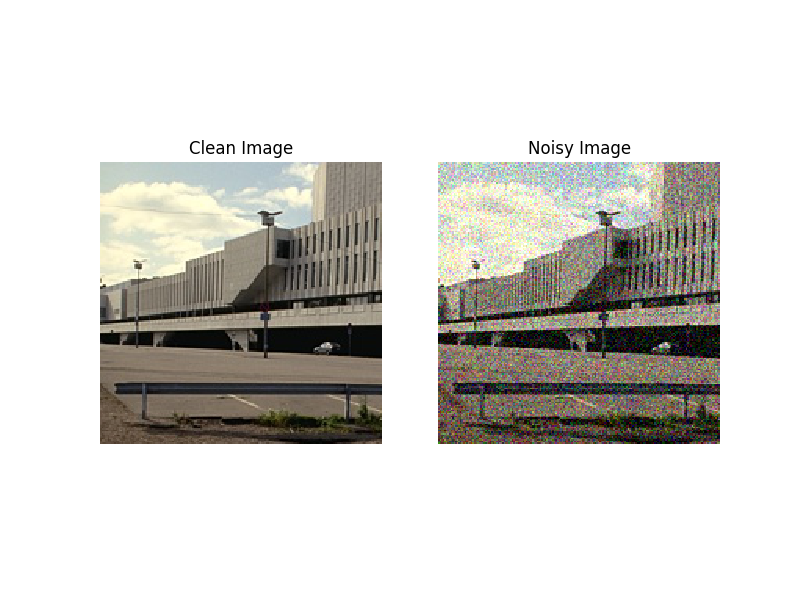

Text(0.5, 1.0, 'Noisy Image')

In [7]:
sig = 30
train_set = NoisyBSDSDataset(dataset_root_dir,'train', (180,180), sig)
test_set = NoisyBSDSDataset(dataset_root_dir, 'test', (320,320), sig)

x,d = test_set[12]
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
myimshow(d)
plt.title('Clean Image')
plt.subplot(1,2,2)
myimshow(x)
plt.title('Noisy Image')

## 3 DnCNN

### 4

In [8]:
class NNRegressor(nt.NeuralNetwork):
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.MSE = nn.MSELoss()
    def criterion(self, y, d):
        return self.MSE(y, d)

### 5

In [9]:
class DnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=(1,1)))
        for k in range(D):
            self.conv.append(nn.Conv2d(C, C,3,padding = (1,1))) 
        self.conv.append(nn.Conv2d(C, 3, 3, padding=(1,1)))
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = self.conv[i+1](h)
            h = self.bn[i](h)
            h = F.relu(h)
        y = self.conv[D+1](h) + x
        return y

### 6

<IPython.core.display.Javascript object>


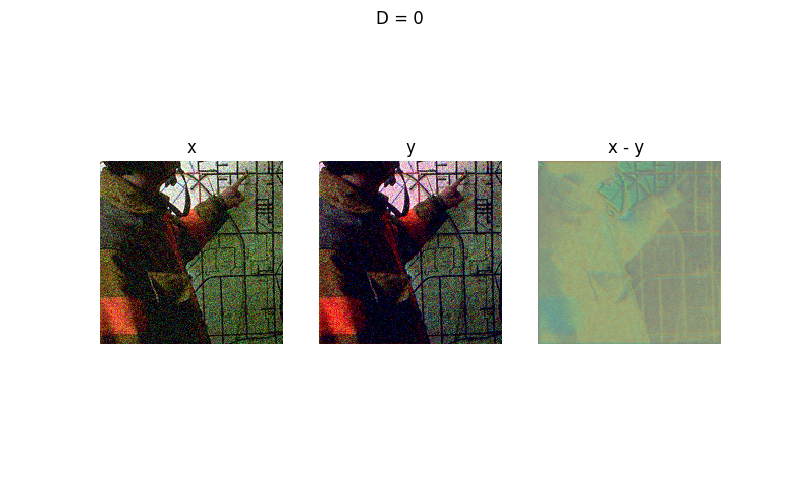

<IPython.core.display.Javascript object>


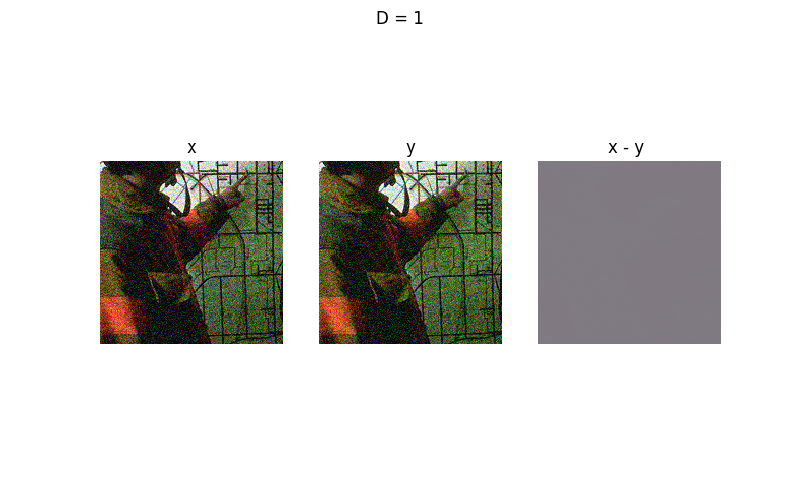

<IPython.core.display.Javascript object>


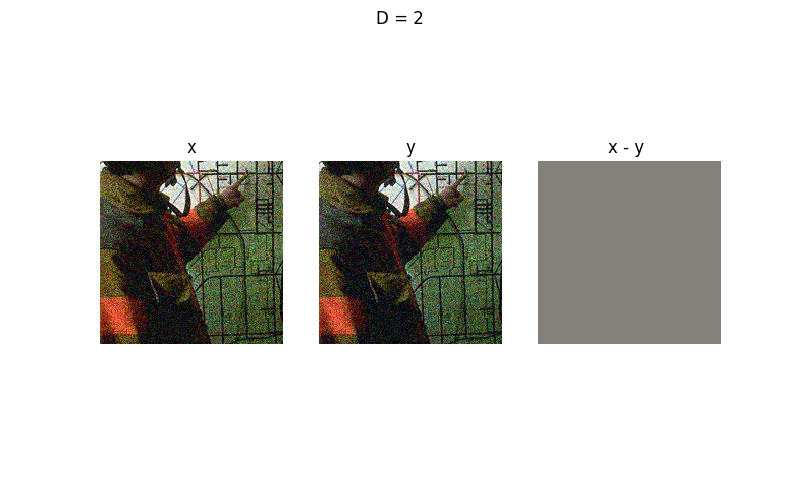

<IPython.core.display.Javascript object>


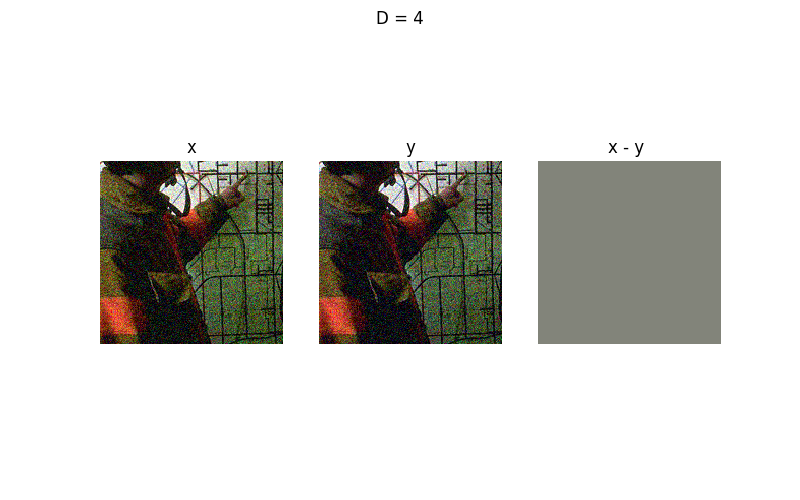

<IPython.core.display.Javascript object>


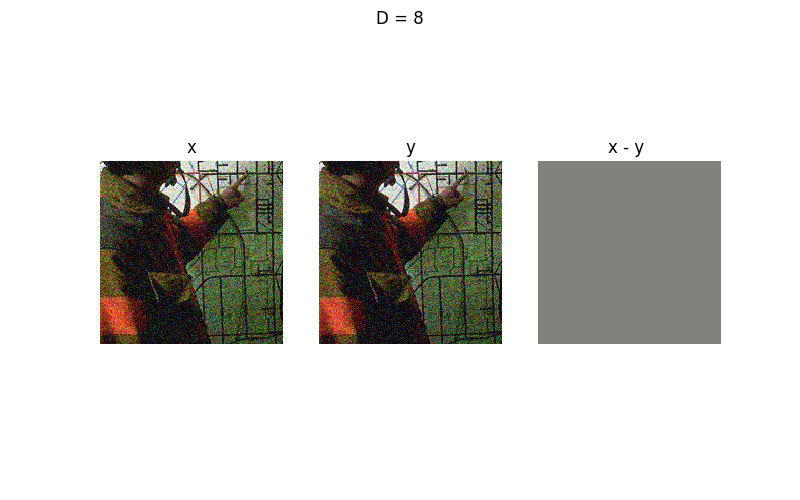

In [10]:
x,_ = train_set[-1]
d_list = [0,1,2,4,8]
x = x[None]
for D in d_list:
    net = DnCNN(D)
    y=net.forward(x)
    y=y.detach()

    fig = plt.figure(figsize=(8,5))
    fig.suptitle(f'D = {D}')

    plt.subplot(1,3,1)
    myimshow(x[0])
    plt.title('x')

    plt.subplot(1,3,2)
    myimshow(y[0])
    plt.title('y')

    plt.subplot(1,3,3)
    myimshow(x[0] - y[0])
    plt.title('x - y ')
    fig.show()

The difference image is pretty much constant for $D>0$, meaning the gradient will be close to 0, meaning there is not much of an error here, so backprop will not learn very much. This is in part because of the initialization scheme, which we will see next has large impact on the results.

### 7

In [11]:
 class DnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=(1,1)))
        for k in range(D):
            self.conv.append(nn.Conv2d(C, C,3,padding = (1,1)))
        self.conv.append(nn.Conv2d(C, 3, 3, padding=(1,1)))
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
        for k in range(D+1):
            nn.init.kaiming_normal_(self.conv[k].weight.data) 
            if(k!=D):
                nn.init.constant_(self.bn[k].weight.data, 1.25 * np.sqrt(C))
            
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = self.conv[i+1](h)
            h = self.bn[i](h)
            h = F.relu(h)
        
        y = self.conv[D+1](h) + x
        return y

### 8

<IPython.core.display.Javascript object>


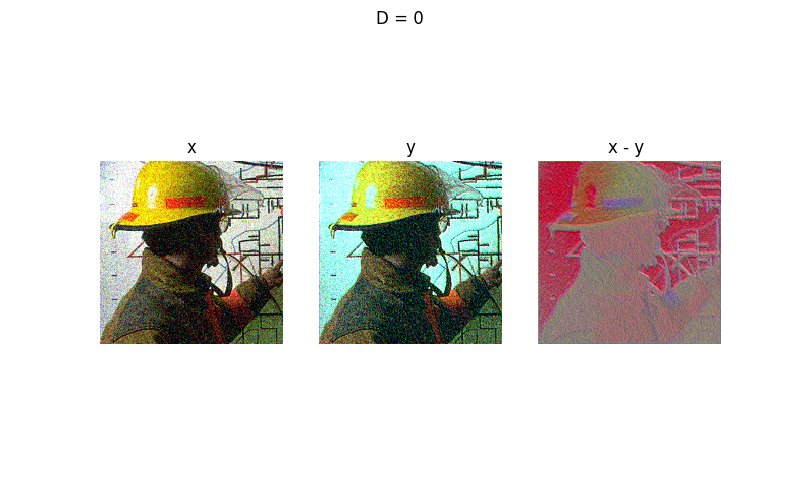

<IPython.core.display.Javascript object>


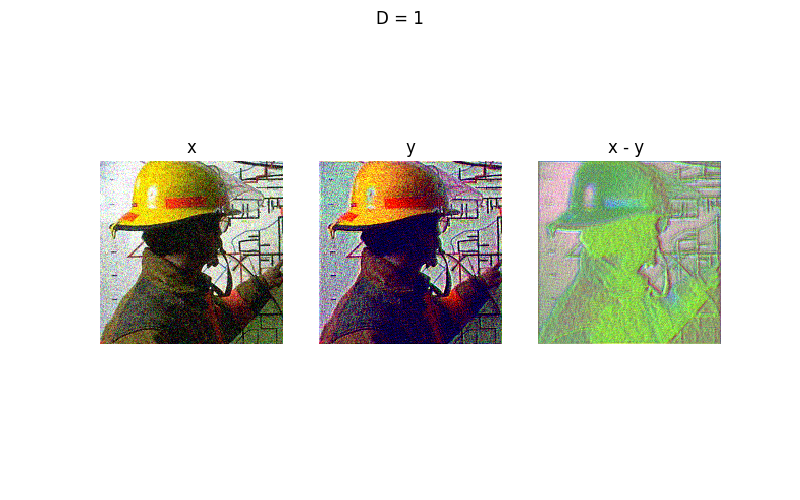

<IPython.core.display.Javascript object>


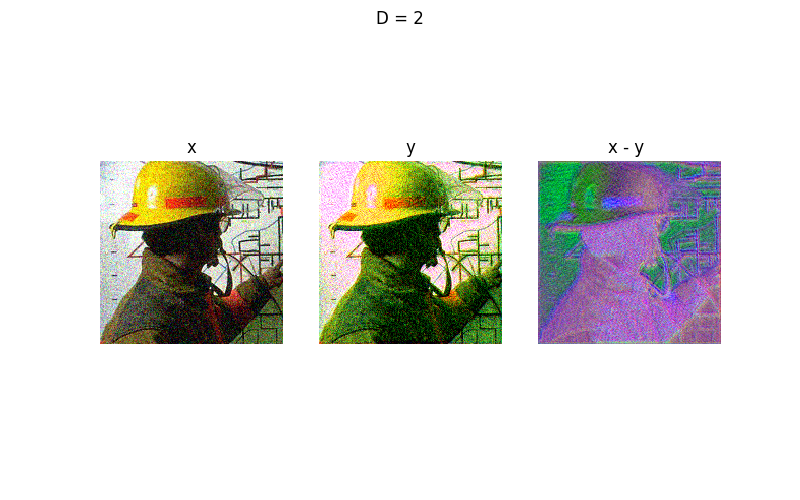

<IPython.core.display.Javascript object>


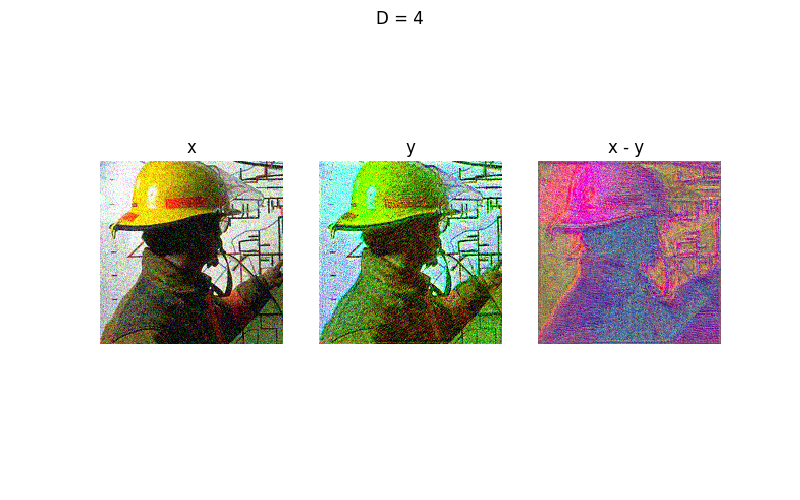

<IPython.core.display.Javascript object>


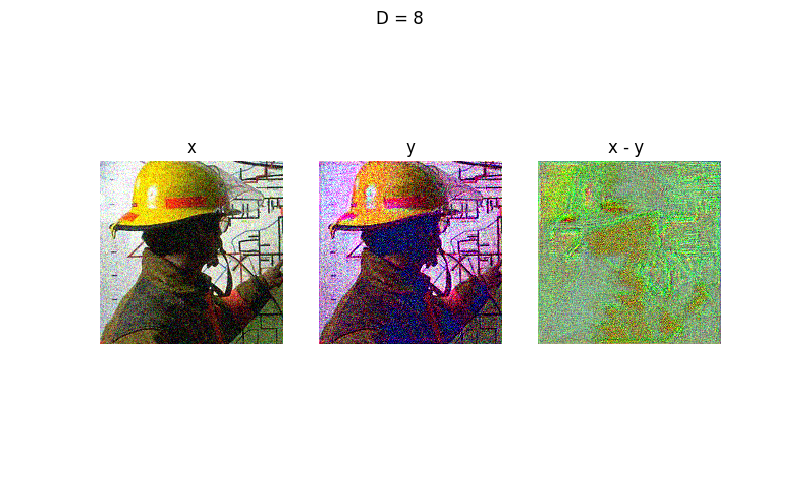

In [12]:
x,_ = train_set[-1]
d_list = [0,1,2,4,8]
x = x[None]
for D in d_list:
    net = DnCNN(D)
    y=net.forward(x)
    y=y.detach()

    fig = plt.figure(figsize=(8,5))
    fig.suptitle(f'D = {D}')

    plt.subplot(1,3,1)
    myimshow(x[0])
    plt.title('x')

    plt.subplot(1,3,2)
    myimshow(y[0])
    plt.title('y')

    plt.subplot(1,3,3)
    myimshow(x[0] - y[0])
    plt.title('x - y ')
    fig.show()

Now with He's initialization there is considerable difference, the error is much more meaningful. This could be because this initialization scheme preserves some of the statistics of the weights by layer, so that the gradient would be more significant. This would imply that backprop will learn more relevant information, and the updates to the weights will be noticeable. 

### 9

In [13]:
class DenoisingStatsManager(nt.StatsManager):        
    def __init__(self):        
        super(DenoisingStatsManager, self).__init__()
        
    def init(self):
        super(DenoisingStatsManager, self).init()
        self.PSNR = 0
        
    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)
        n = np.prod(y.shape)
        self.PSNR += 10*torch.log10(4*n/torch.norm(y-d)**2)
        
    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        PSNR = self.PSNR / self.number_update
        return {'loss': loss, 'PSNR': PSNR}

### 10

In [14]:
lr = 1e-3
DnCNN6 = DnCNN(6)
DnCNN6 = DnCNN6.to(device)
adam = torch.optim.Adam(DnCNN6.parameters(), lr = lr)
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(DnCNN6, train_set, test_set, adam, stats_manager,
                     output_dir="denoising1", batch_size = 4,perform_validation_during_training=True)

### 11

In [15]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(exp.net.device))[0]
        axes[0][0].clear()
        axes[0][1].clear()
        axes[1][0].clear()
        axes[1][1].clear()      
        
        myimshow(noisy, ax=axes[0][0])
        axes[0][0].set_title('Noisy')
        myimshow(denoised, ax=axes[0][1])
        axes[0][1].set_title('Denoised')

        axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label="training loss")
        axes[1][1].plot([exp.history[k][0]['PSNR'] for k in range(exp.epoch)],
                 label="training PSNR")
        
        axes[1][0].set_xlabel('Epoch')
        axes[1][0].set_ylabel('Loss')
        axes[1][0].legend()
        
        axes[1][1].set_xlabel('Epoch')
        axes[1][1].set_ylabel('PSNR')
        axes[1][1].legend()

        plt.tight_layout()
        fig.canvas.draw()


<IPython.core.display.Javascript object>


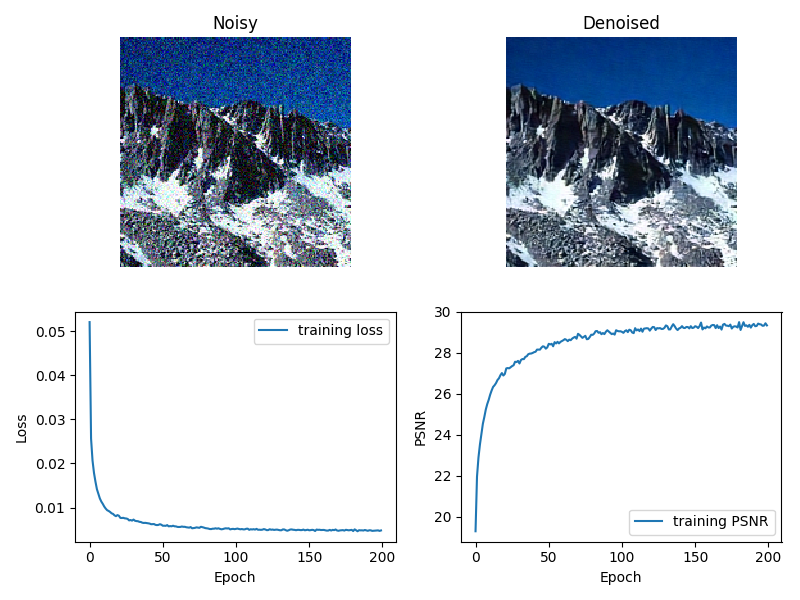

Start/Continue training from epoch 200
Finish training for 200 epochs


In [24]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,6))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,noisy=test_set[73][0]))

### 12

<IPython.core.display.Javascript object>


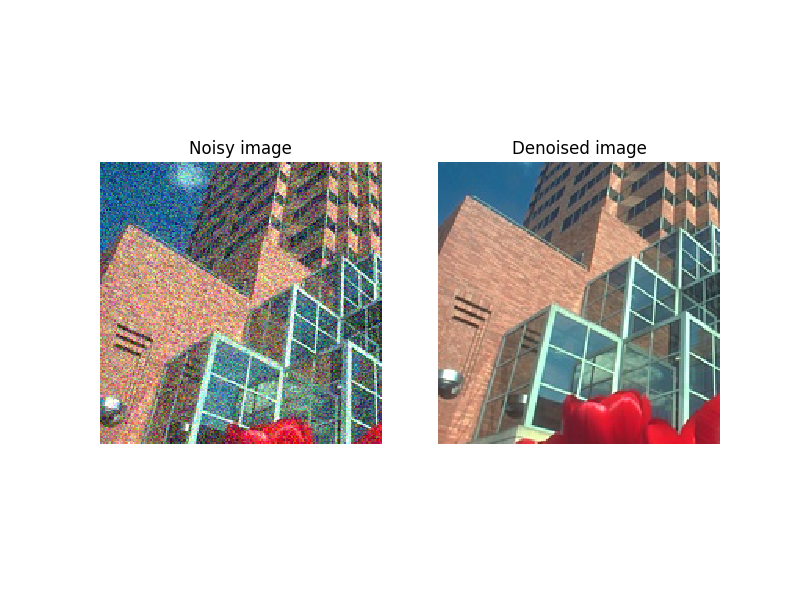

Text(0.5, 1.0, 'Denoised image')

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 6), sharex='all', sharey='all')
myimshow(test_set[55][0],ax = axes[0])
axes[0].set_title('Noisy image')

myimshow(test_set[55][1],ax = axes[1])
axes[1].set_title('Denoised image')

<IPython.core.display.Javascript object>


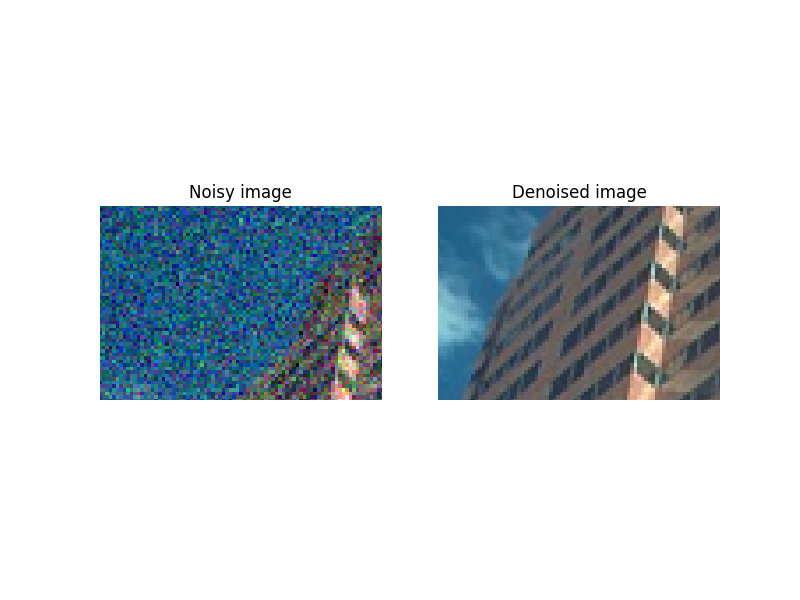

Text(0.5, 1.0, 'Denoised image')

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 6), sharex='all', sharey='all')
myimshow(test_set[55][0],ax = axes[0])
axes[0].set_title('Noisy image')

myimshow(test_set[55][1],ax = axes[1])
axes[1].set_title('Denoised image')

<IPython.core.display.Javascript object>


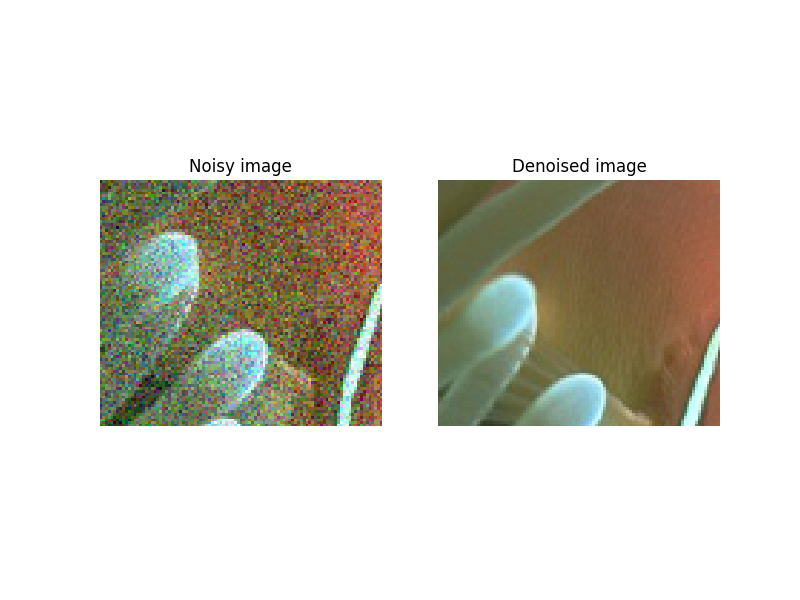

Text(0.5, 1.0, 'Denoised image')

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 6), sharex='all', sharey='all')
myimshow(test_set[91][0],ax = axes[0])
axes[0].set_title('Noisy image')

myimshow(test_set[91][1],ax = axes[1])
axes[1].set_title('Denoised image')

The quality of the reconstruction is quite good, considering the very high levels of noise in the images. However, we can see that the reconstruction is not perfect and there is some blur around the edges, and some artifacts are created in the smooth areas (sky in the image from the previous section, orage head of the fish here). Nevertheless, the results are good, especially compared to classical non-learning methods. Note that these images are zoomed in to show the difference more clearly.

### 13

The first and last conv+relu layers have $2\times(3\times3\times3\times64) = 3456$ parameters.
There are D layers of Conv+BN+RelU, each add $64\times64\times3\times3 = 36,864$ parameters. So in total the number of parameters is $36,864D + 3456$. The receptive field corresponding to depth D is $(2D + 5)$, because each 3x3 convolution adds 2, and there are D+2 (first and last always happen, regardless of D) convolutional layers.

### 14

According to the previous section, $2D + 5 = 33 \rightarrow D = 14$. This would result in a very deep network, with about 520K parameters. If for D = 6 the network had ~225K parameters and took ~20 minutes to train, it would take much longer to train the deeper network with so much more parameters to propagate the gradient through, but the result would likely be of higher quality.

## 4 U-Net like CNNs

### 15

In [18]:
 class UDnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        super(UDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=(1,1)))
        for k in range(D):
            self.conv.append(nn.Conv2d(C, C,3,padding = (1,1)))
        self.conv.append(nn.Conv2d(C, 3, 3, padding=(1,1)))
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
        for k in range(D+1):
            nn.init.kaiming_normal_(self.conv[k].weight.data) 
            if(k!=D):
                nn.init.constant_(self.bn[k].weight.data, 1.25 * np.sqrt(C))
    def comb(self,idx,h):
        h = self.conv[idx](h)
        h = self.bn[idx-1](h)
        h = F.relu(h)
        
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        feats, spat_dims, maxpool_idxs= [0],[0],[0]
        mid = int(D/2)
        for k in range(1,D+1):
            if (k<mid):
                self.comb(k,h)
                spat_dims.append(h.size())
                h, idxs = F.max_pool2d(h,kernel_size = 2,stride = 2,return_indices = True)
                feats.append(h)
                maxpool_idxs.append(idxs)
            elif (k==mid or k==mid+1):
                self.comb(k,h)
            else:
                h += feats[D-k+1]   
                h /= 2**0.5
                idxs = maxpool_idxs[D-k+1]
                spat_dim = spat_dims[D-k+1]
                h = F.max_unpool2d(h,idxs,kernel_size = 2,stride = 2,output_size = spat_dim)
                self.comb(k,h)
        h = (h+h)/2**0.5
        y = self.conv[D+1](h) + x
        return y

### 16

In [19]:
lr = 1e-3
UDnCNN6 = UDnCNN(6)
UDnCNN6 = UDnCNN6.to(device)
adam = torch.optim.Adam(UDnCNN6.parameters(), lr = lr)
stats_manager = DenoisingStatsManager()
exp2 = nt.Experiment(UDnCNN6, train_set, test_set, adam, stats_manager,
                     output_dir="denoising2", batch_size = 4,perform_validation_during_training=True)

<IPython.core.display.Javascript object>


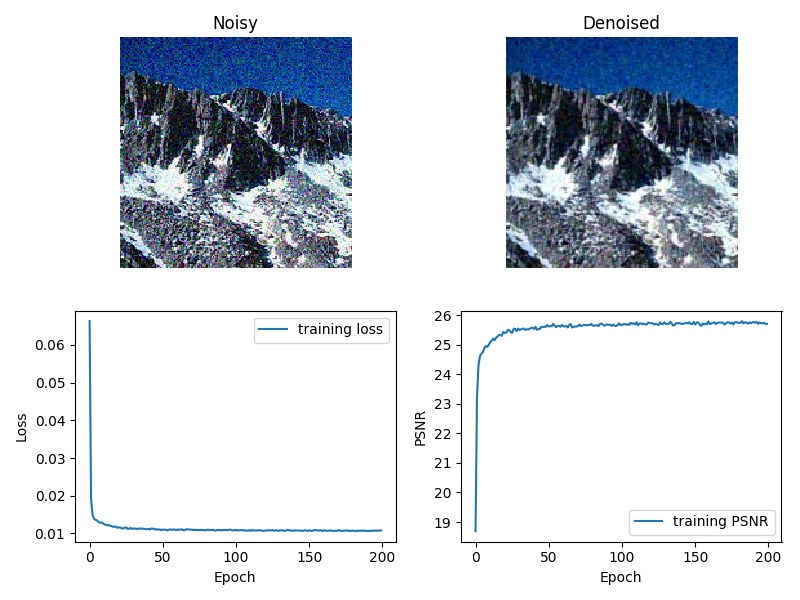

Start/Continue training from epoch 200
Finish training for 200 epochs


In [20]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,6))
exp2.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,noisy=test_set[73][0]))

### 17

This network has the same number of parameters as before, since pooling operations don't add any parameters. So $36,864D + 3456$.

Next, the receptive field here is a (telescopic?) series repeating $\frac{D}{2}$ times. The receptive field is then given by the result which is $2^{\frac{D}{2}+1}+5$, because of the pooling layers in the contracting and expansive paths.

Since UDnCNN has larger receptive field and same number of parameters, I would expect it to outperform DnCNN. However, as is evident from the results, the opposite is true. This could be because even though the receptive field is larger, the location of the important features is lost because of the unpooling as mentioned on Piazza, which is why there are so many artifacts in the restoration (like in the sky in the above picture) and the PSNR is considerably lower than for DnCNN because the network still kept quite a lot of the noise component of the images.

### 18

In [18]:
print(exp1.evaluate())
print(exp2.evaluate())

{'loss': 0.004698672201484442, 'PSNR': tensor(29.4323, device='cuda:0')}
{'loss': 0.010662851594388486, 'PSNR': tensor(25.7763, device='cuda:0')}


## 5 U-Net like CNNs with dilated convolutions

### 19

In [21]:
class DUDnCNN(NNRegressor):
    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=(1,1)))
        for i in range(D):
            dil = int(2**(min(i,D/2-1)-max(0,i-D/2)))
            self.conv.append(nn.Conv2d(C, C,3,padding = (dil,dil), dilation=(dil,dil))) 
        self.conv.append(nn.Conv2d(C, 3, 3, padding=(1,1)))
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
        for k in range(D+1):
            nn.init.kaiming_normal_(self.conv[k].weight.data)
            if(k!=D):
                nn.init.constant_(self.bn[k].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        feats =[0]
        mid = int(D/2) 
        for k in range(1,D+1):
            if(k>mid+1):
                h += feats[D-k+1]
                h /= 2**0.5
            torch.backends.cudnn.benchmark = True
            h = self.conv[k](h)
            torch.backends.cudnn.benchmark = False

            h = self.bn[k-1](h)
            h = F.relu(h)
            if(k<mid):
                feats.append(h)
        h = (h + h)/2**0.5
        y = self.conv[D+1](h) + x
        return y

### 20

See above.

### 21

In [22]:
lr = 1e-3
DUDnCNN6 = DUDnCNN(6)
DUDnCNN6 = DUDnCNN6.to(device)
adam = torch.optim.Adam(DUDnCNN6.parameters(), lr = lr)
stats_manager = DenoisingStatsManager()
exp3 = nt.Experiment(DUDnCNN6, train_set, test_set, adam, stats_manager,
                     output_dir="denoising3", batch_size = 4,perform_validation_during_training=True)

<IPython.core.display.Javascript object>


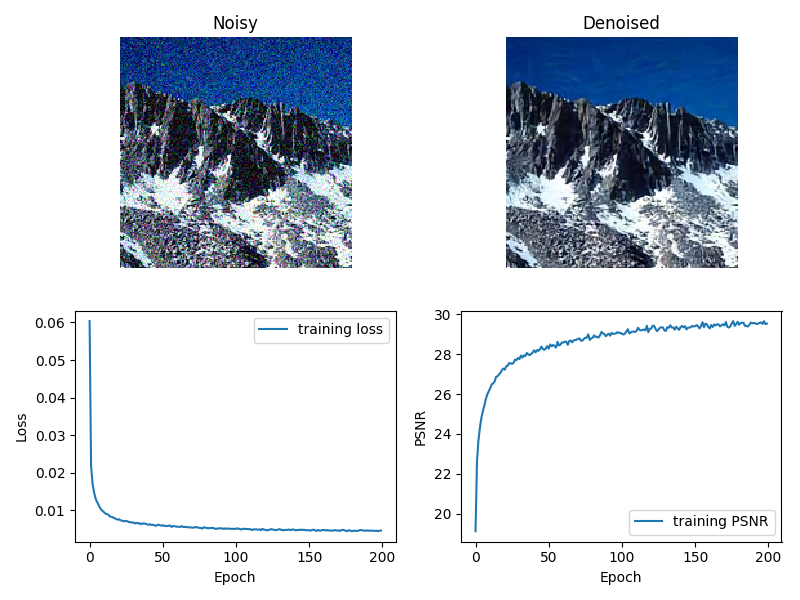

Start/Continue training from epoch 200
Finish training for 200 epochs


In [23]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,6))
exp3.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,noisy=test_set[73][0]))

Seems to be a bit better edge preservation but perhaps more artifacts. Comparable results to DnCNN either way, also in terms of PSNR.

### 22

In [44]:
exp3.evaluate()

{'loss': 0.0046157547924667594, 'PSNR': tensor(29.5380, device='cuda:0')}

The PSNR results are: 29.43 dB for DnCNN, 25.76 dB for UDnCNN and 29.54 for DUDnCNN. We can see the results for this architecture are much better than for UDnCNN, probably because of the dilated convolutions. The results are also better than DnCNN, likely because of the larger receptive field. This method seems like the best of both worlds between UDnCNN and DnCNN, and the PSNR and actual reconstructed images seem to show this, shown next.

In [37]:
x,_ = test_set[63]
x = x[None]
DnCNN6=DnCNN6.to('cpu')
comp_1_1=DnCNN6.forward(x)
comp_1_1=comp_1_1.detach()
UDnCNN6=UDnCNN6.to('cpu')
comp_1_2 = UDnCNN6.forward(x)
comp_1_2 = comp_1_2.detach()
DUDnCNN6=DUDnCNN6.to('cpu')
comp_1_3=DUDnCNN6.forward(x)
comp_1_3 = comp_1_3.detach()

x,_ = test_set[72]
x = x[None]
DnCNN6=DnCNN6.to('cpu')
comp_2_1=DnCNN6.forward(x)
comp_2_1=comp_2_1.detach()
UDnCNN6=UDnCNN6.to('cpu')
comp_2_2 = UDnCNN6.forward(x)
comp_2_2 = comp_2_2.detach()
DUDnCNN6=DUDnCNN6.to('cpu')
comp_2_3=DUDnCNN6.forward(x)
comp_2_3 = comp_2_3.detach()

<IPython.core.display.Javascript object>


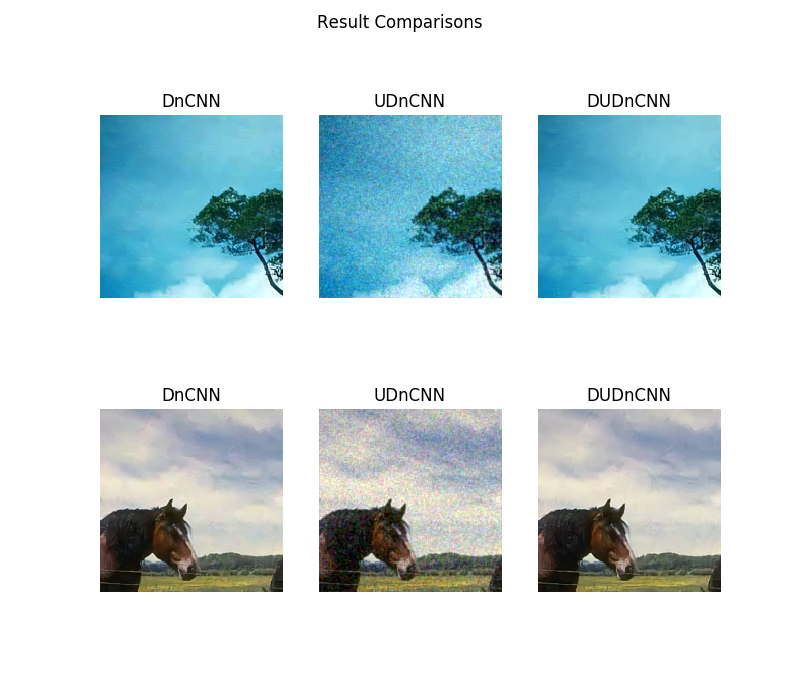

Text(0.5, 1.0, 'DUDnCNN')

In [38]:
fig, axes = plt.subplots(nrows = 2, ncols=3, figsize=(8, 7), sharex='all', sharey='all')
fig.suptitle('Result Comparisons')
myimshow(comp_1_1[0], ax = axes[0,0])
axes[0,0].set_title('DnCNN')

myimshow(comp_1_2[0],ax = axes[0,1])
axes[0,1].set_title('UDnCNN')

myimshow(comp_1_3[0],ax = axes[0,2])
axes[0,2].set_title('DUDnCNN')

myimshow(comp_2_1[0],ax = axes[1,0])
axes[1,0].set_title('DnCNN')

myimshow(comp_2_2[0],ax = axes[1,1])
axes[1,1].set_title('UDnCNN')

myimshow(comp_2_3[0],ax = axes[1,2])
axes[1,2].set_title('DUDnCNN')

We can see from the above that UDnCNN has more artifacts and noise than the other 2 architectures, while DUDnCNN seem to have the least artifacts around the smooth areas and slightly better edge preservation. Overall the results match what was expected. It's difficult to see the differences just using the naked eye, especially between DnCNN and DUDCNN.

### 23

DUDnCNN has the same number of parameters as DnCNN and UDnCNN, meaning $36,864D + 3456$. Its receptive field is the same as UDnCNN, meaning $2^{\frac{D}{2}+1}+5.$

As mentioned previously, this architecture takes the best of both worlds of DnCNN and UDnCNN, as it has the same number of parameters, but more informative features with location because of the dilated convolutions.